# Benchmark de Séries Temporais
Este notebook executa várias previsões da produção de leite usando modelos estatísticos como Naive, Média, Drift, Holt, Holt-Winters e ARIMA (via `statsmodels`) e cria uma aplicação web interativa com Gradio para melhor visualização das previsões.

In [1]:
import pandas as pd
import gradio as gr
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import Holt, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from google.colab import files
import io


## Upload do arquivo CSV

In [2]:
uploaded = files.upload()
file = list(uploaded.keys())[0]
data = pd.read_csv(io.BytesIO(uploaded[file]), header=None)
data.head()

Saving monthly-milk-production-pounds-p.csv to monthly-milk-production-pounds-p.csv


,0
0,589
1,561
2,640
3,656
4,727


## Definir parâmetros da previsão

In [3]:
forecast_horizon = 24  # número de períodos a prever
methods = {
    'naive': True,
    'mean': True,
    'drift': True,
    'holt': True,
    'hw': True,
    'arima': True,
}

## Funções auxiliares para previsão e visualização

In [4]:
def plot_forecasts(actual, forecasts, titles):
    plt.figure(figsize=(10,6))
    plt.plot(actual, label="Dados Atuais")
    for forecast, title in zip(forecasts,titles):
        plt.plot(np.arange(len(actual), len(actual)+ len(forecast)), forecast, label=title)
    plt.legend()
    plt.title("Benchmark de Séries Temporais")
    plt.grid(True)
    plt.show()

def forecast_methods(train, h, methods):
    forecast = []
    titles = []

    if methods['naive']:
        naive_forecast = np.tile(train.iloc[-1],h)
        forecast.append(naive_forecast)
        titles.append("Naive")
    if methods['mean']:
        mean_forecast = np.tile(train.mean(),h)
        forecast.append(mean_forecast)
        titles.append("Mean")
    if methods['drift']:
        drift_forecast = train.iloc[-1] + (np.arange(1,h+1) *
                            ((train.iloc[-1] - train.iloc[0]) / (len(train)-1)))
        forecast.append(drift_forecast)
        titles.append("Drift")
    if methods['holt']:
        holt_forecast = Holt(train).fit().forecast(h)
        forecast.append(holt_forecast)
        titles.append("Holt")
    if methods['hw']:
        hw_forecast = ExponentialSmoothing(train,seasonal='additive',
                        seasonal_periods=12).fit().forecast(h)
        forecast.append(hw_forecast)
        titles.append("HW Additive")
    if methods['arima']:
        arima_model = ARIMA(train, order=(1,1,1)).fit()
        arima_forecast = arima_model.forecast(steps=h)
        forecast.append(arima_forecast)
        titles.append("ARIMA")

    return forecast, titles

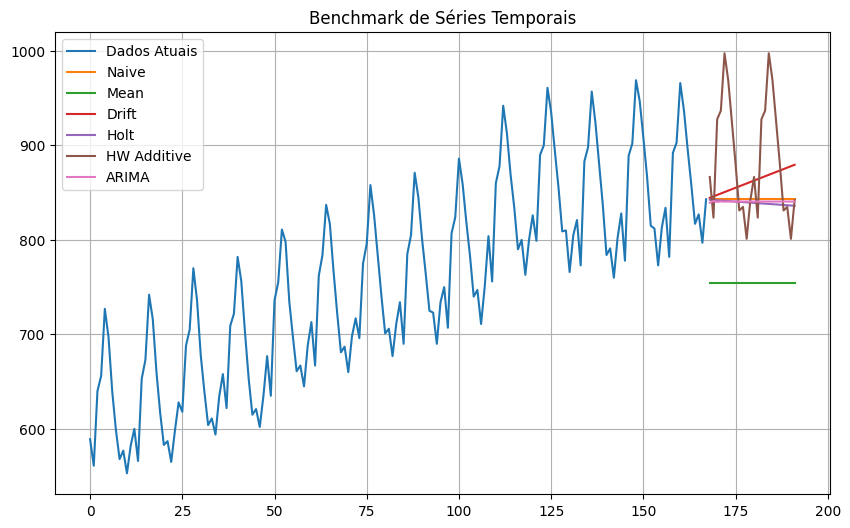

In [5]:
train = data.iloc[:,0]
forecasts, titles = forecast_methods(train, forecast_horizon, methods)
plot_forecasts(train, forecasts, titles)

In [ ]:
#Gerando a aplicação web desse benchmark com gradio.
def forecast_benchmark(file, forecast_horizon, naive, mean, drift, holt, hw, arima):
    data = pd.read_csv(file.name, header=None)
    train = data.iloc[:, 0]

    methods = {
        'naive': naive,
        'mean': mean,
        'drift': drift,
        'holt': holt,
        'hw': hw,
        'arima': arima,
    }

    forecasts, titles = forecast_methods(train, forecast_horizon, methods)

    # Plotting the forecasts
    plt.figure(figsize=(10, 6))
    plt.plot(train, label="Dados Atuais")
    for forecast, title in zip(forecasts, titles):
        plt.plot(np.arange(len(train), len(train) + len(forecast)), forecast, label=title)
    plt.legend()
    plt.title("Benchmark de Séries Temporais")
    plt.grid(True)

    # Return the plot as an image
    plt.savefig("forecast_plot.png")
    plt.close()
    return "forecast_plot.png"

# Gradio interface
iface = gr.Interface(
    fn=forecast_benchmark,
    inputs=[
        gr.File(label="Upload CSV file"),
        gr.Slider(minimum=1, maximum=60, step=1, value=24, label="Forecast Horizon"),
        gr.Checkbox(label="Naive"),
        gr.Checkbox(label="Mean"),
        gr.Checkbox(label="Drift"),
        gr.Checkbox(label="Holt"),
        gr.Checkbox(label="Holt-Winters (Additive)"),
        gr.Checkbox(label="ARIMA"),
    ],
    outputs=gr.Image(label="Forecast Plot"),
    title="Time Series Forecasting Benchmark",
    description="Upload a CSV file with your time series data (single column) and select the forecasting methods to compare."
)

iface.launch(debug=True)


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://e9735204dc16ff1a3d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
